In [23]:
import os, os.path
import csv
import numpy as np
import sys
from scipy.spatial import distance
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
train_features_path = 'train_sift_features'
test_features_path = 'test_sift_features'
train_labels_path = 'train_labels.csv'
test_labels_path = 'test_labels.csv'

In [3]:
def read_features(path, mode):
    total_features = []
    features_count = []
    n = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
    for i in range(1,n+1):
        count = 0
        file = path + '/' + str(i) + '_' + mode + '_sift.csv'
        file_read = csv.reader(open(file,'r'))
        for j in file_read:
            total_features.append(list(map(int, j[4:])))
            count += 1
        features_count.append(count)
    return total_features, features_count

In [4]:
def read_labels(path):
    with open(path, 'r') as f:
        f = list(csv.reader(f, delimiter = ','))
        return list(map(int, f[0]))

In [5]:
train_features, train_features_count = read_features(train_features_path, 'train')
test_features, test_features_count = read_features(test_features_path, 'test')
train_labels = read_labels(train_labels_path)
test_labels = read_labels(test_labels_path)

In [6]:
def kmeans(train_features, test_features, k):
    km = KMeans(k)
    km.fit(train_features + test_features)
    centroid = km.cluster_centers_
    labels = km.labels_
    return centroid, labels

In [7]:
k = 8
km_centroid, km_labels = kmeans(train_features, test_features, k)
#print(km_centroid)
print(km_labels)

[6 1 3 ... 1 1 6]


In [8]:
def bag_of_words(features, features_count, km_centroid, k):
    bow = []
    temp = [0]*k
    index = 0
    l = len(features)
    count = 0
    for i in range(l):
        min_dist = sys.maxsize
        min_index = 0
        for j in range(k):
            temp_dist = np.linalg.norm(features[i] - km_centroid[j])
            if temp_dist < min_dist:
                min_dist = temp_dist
                min_index = j
        temp[min_index] += 1
        count+=1
        if(count == features_count[index]):
            index += 1
            bow.append(temp)
            temp = [0]*k
            count = 0
    return bow

In [9]:
train_bow = bag_of_words(train_features, train_features_count, km_centroid, k)
test_bow = bag_of_words(test_features, test_features_count, km_centroid, k)

In [19]:
knn_n = 5
knn = KNeighborsClassifier(n_neighbors=knn_n)
knn.fit(train_bow, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [14]:
predicted_labels = knn.predict(test_bow)

In [30]:
print("Confusion matrix = \n",confusion_matrix(test_labels, predicted_labels))

Confusion matrix :
 [[55  0 21  0  9 12  0  3]
 [ 0 73  0  8  6  3  4  6]
 [29  0 37  6  9 12  2  5]
 [ 4 15  0 39  9 11 13  9]
 [ 6  5  6  6 36 17 17  7]
 [16  5  8  8 19 29  8  7]
 [ 2  4  1 11 19 18 37  8]
 [10  8  7 19 14 11 10 21]]


In [29]:
print(classification_report(test_labels, predicted_labels, target_names=['0','1','2','3','4','5','6','7']))

             precision    recall  f1-score   support

          0       0.45      0.55      0.50       100
          1       0.66      0.73      0.70       100
          2       0.46      0.37      0.41       100
          3       0.40      0.39      0.40       100
          4       0.30      0.36      0.33       100
          5       0.26      0.29      0.27       100
          6       0.41      0.37      0.39       100
          7       0.32      0.21      0.25       100

avg / total       0.41      0.41      0.40       800



In [32]:
print("accuracy :",accuracy_score(test_labels, predicted_labels)*100,"%")

accuracy : 40.875 %


In [35]:
error = []
n = 40
for i in range(1, n):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_bow, train_labels)
    pred_i = knn.predict(test_bow)
    error.append(np.mean(pred_i != test_labels))

In [36]:
print(error)

[0.64125, 0.6225, 0.61125, 0.58625, 0.59125, 0.58625, 0.59, 0.5825, 0.58375, 0.5825, 0.57875, 0.57625, 0.5725, 0.5725, 0.57375, 0.575, 0.5725, 0.57, 0.57125, 0.58, 0.5725, 0.56875, 0.5625, 0.55625, 0.56375, 0.57125, 0.57625, 0.56875, 0.57, 0.56625, 0.57125, 0.56375, 0.5675, 0.56125, 0.56125, 0.56125, 0.5625, 0.57, 0.56625]


Text(0, 0.5, 'Mean Error')

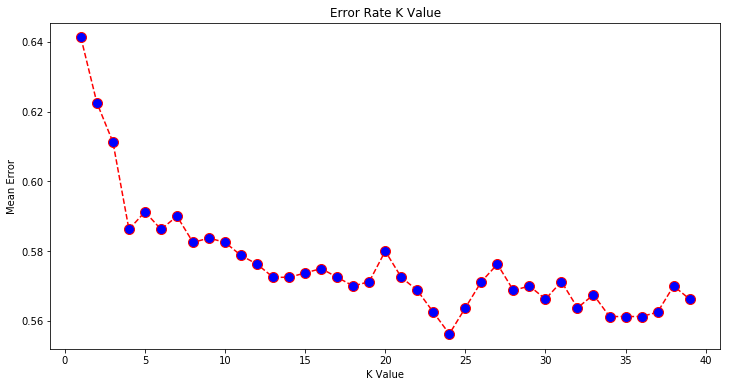

In [37]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, n), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')